In [1]:
import numpy as np
import geopandas
import pandas as pd
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from tqdm import tqdm
import sklearn
from shapely.geometry import Polygon
from shapely import wkt
import re

TODO: connect the arrays to the dataframes, so I can ID which datapoints are outliers

In [2]:
county_conn_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_conn.pkl') 
sci_dist_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\sci_dist.pkl')
geo_dist = np.load(r'C:\Users\mgm24\Documents\datasets\geo_dist.npy')
sci_dist_df.head(5)

fr_loc,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
user_loc,,,,,,,,,,,,,,,,,,,,,
1001,1.117710e-07,9.804210e-06,7.443744e-06,3.927421e-06,1.488184e-05,2.330883e-06,0.000001,0.000014,0.000009,0.000028,...,0.000573,0.000597,0.000418,0.000810,0.000730,0.000561,0.000344,0.000731,0.001028,0.001453
1003,9.804210e-06,3.172975e-07,1.997443e-05,1.228879e-05,1.490024e-05,3.052969e-05,0.000006,0.000016,0.000025,0.000026,...,0.000805,0.000371,0.000298,0.000522,0.000279,0.000634,0.000158,0.000521,0.000717,0.000442
1005,7.443744e-06,1.997443e-05,2.212110e-08,3.133912e-05,5.388512e-05,1.598885e-07,0.000004,0.000018,0.000006,0.000060,...,0.000738,0.000713,0.001277,0.001645,0.001242,0.001695,0.000350,0.002358,0.001427,0.001580
1007,3.927421e-06,1.228879e-05,3.133912e-05,2.434424e-08,4.175470e-06,1.999440e-05,0.000008,0.000012,0.000028,0.000023,...,0.002273,0.000667,0.000647,0.001488,0.000774,0.001898,0.001058,0.001502,0.001391,0.001019
1009,1.488184e-05,1.490024e-05,5.388512e-05,4.175470e-06,7.533211e-08,7.212926e-05,0.000034,0.000005,0.000038,0.000006,...,0.002457,0.000709,0.000665,0.000320,0.001105,0.000487,0.000668,0.001079,0.000875,0.000513


In [3]:
# vectorize pairwise distances
sci_dist_df = pd.melt(sci_dist_df, ignore_index=False) 
sci_dist = np.asarray(sci_dist_df['value'])
geo_dist = geo_dist.reshape((geo_dist.shape[0]**2,1)) #this reorganizes elements in the same way as pd.melt
sci_dist_df.head(5)

,fr_loc,value
user_loc,,
1001,1001,1.117710e-07
1003,1001,9.804210e-06
1005,1001,7.443744e-06
1007,1001,3.927421e-06
1009,1001,1.488184e-05


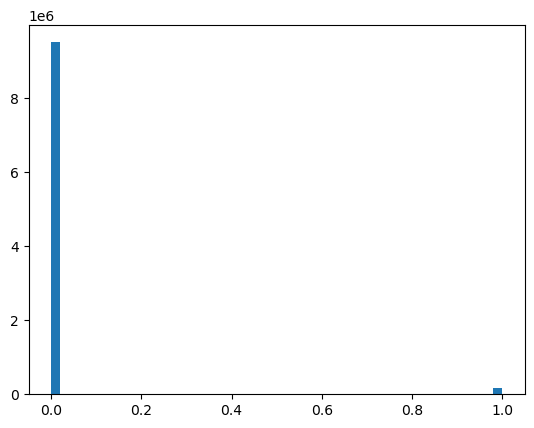

In [4]:
_ = plt.hist(sci_dist, bins=50)

Remove outlier points

In [5]:
print(geo_dist.shape)
# store original arrays for later indexing
og_geo_dist = geo_dist
og_sci_dist = sci_dist
geo_dist = np.delete(geo_dist, np.where(sci_dist>.1))
sci_dist = np.delete(sci_dist, np.where(sci_dist>.1))
print(geo_dist.shape)

(9659664, 1)
(9490482,)


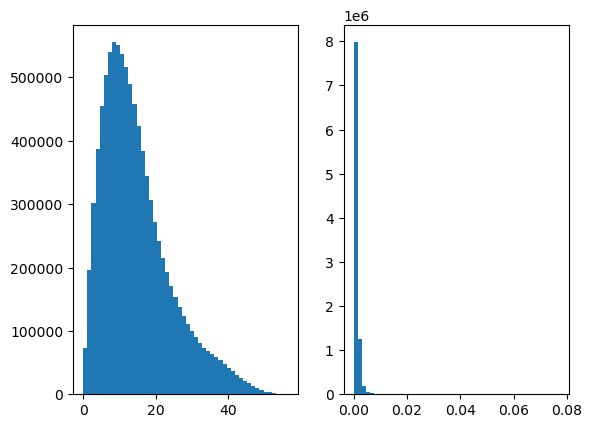

In [6]:
plt.subplot(1,2,1)
_ = plt.hist(geo_dist, bins=50)
plt.subplot(1,2,2)
_ = plt.hist(sci_dist, bins=50)

9487374


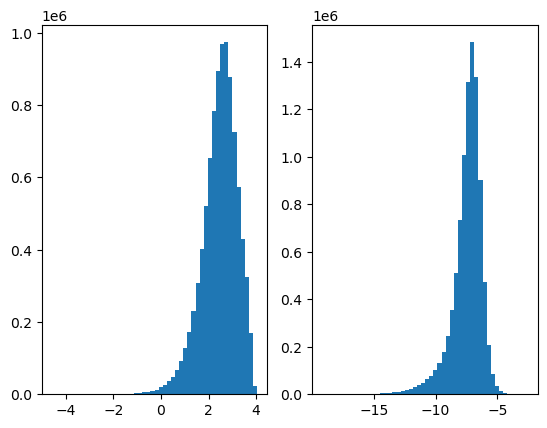

In [7]:
geodist_0idx = np.where(geo_dist>0)[0]
sci_dist = sci_dist[geodist_0idx]
geo_dist = geo_dist[geodist_0idx]
print(len(sci_dist))
plt.subplot(1,2,1)
_ = plt.hist(np.log(geo_dist), bins=50) # +.001 to prevent 0 errors
plt.subplot(1,2,2)
_ = plt.hist(np.log(sci_dist), bins=50)

Text(0, 0.5, 'Social distance')

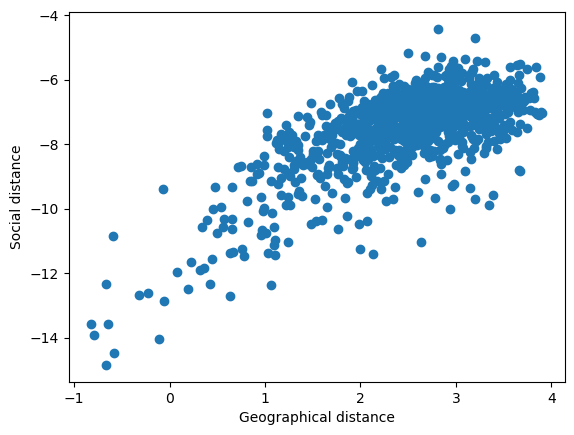

In [8]:
# Only plot a subsample (too many points otherwise) (MAYBE DELETE)
import random
samples = random.sample(range(len(sci_dist)), 1000)
plt.scatter(np.log(geo_dist[samples]), np.log(sci_dist[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social distance')

Let's look at the relationship between geographical distance and social distance. Since we're only interested in when social distance is unexpectadly small when the counties are geographically distant, we'll remove the counties where the geographical distance is small.

Samples with a distance greater than 4.511534669127608: 8538636


Text(0, 0.5, 'Social distance')

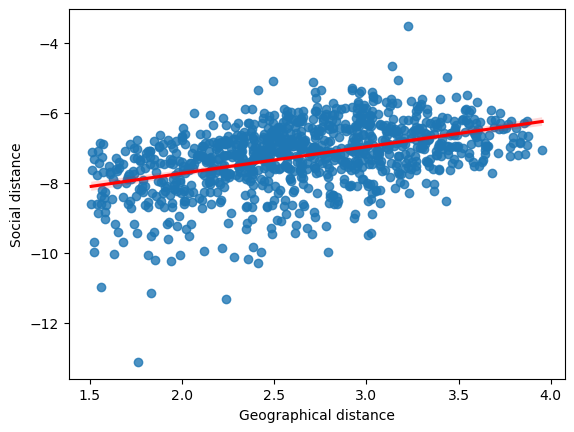

In [9]:
dist = np.percentile(geo_dist, 10)
print('Samples with a distance greater than '+str(dist)+': '+ str(np.sum(geo_dist>dist)))
geo_far = geo_dist[geo_dist>dist]
sci_far = sci_dist[geo_dist>dist]
samples = random.sample(range(len(sci_far)), 1000)
sns.regplot(x=np.log(geo_far[samples]), y=np.log(sci_far[samples]),
           line_kws={"color": "red"})
# plt.scatter(np.log(geo_far[samples]), np.log(sci_far[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social distance')

TODO change: How effective is this model? Let's plot the diagnostic plots for this regression. Looking at the residual plots can also tell us about the outliers we're interested in.

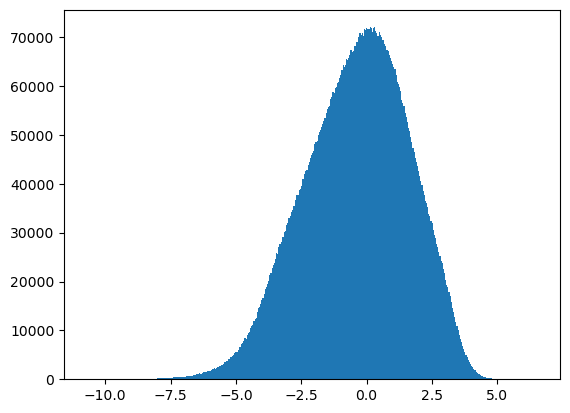

In [10]:
results = sm.OLS(np.log(sci_far), np.log(geo_far)).fit()
residuals = results.resid
_ = plt.hist(residuals, bins=400)
# plt.xlim(-.003, .006)

The residuals have a heavy left tail -- meaning there is a lot of points where the actual social distance is much less than the predicted social distance -- the data we're intersted in!

In [11]:
np.where(geo_dist>dist)[0]
sci_dist_df.reset_index(inplace=True, level=0)
sci_dist_df

,user_loc,fr_loc,value
0,1001,1001,1.117710e-07
1,1003,1001,9.804210e-06
2,1005,1001,7.443744e-06
3,1007,1001,3.927421e-06
4,1009,1001,1.488184e-05
...,...,...,...
9659659,56037,56045,6.560604e-06
9659660,56039,56045,2.362502e-05
9659661,56041,56045,7.041658e-06
9659662,56043,56045,1.723419e-06


In [12]:
# drop the same elements from the df we dropped from the arrays
print(sci_dist_df.shape)
print(geo_dist.shape)
sci_dist_df.drop(sci_dist_df[sci_dist_df['value']>.1].index, inplace=True)
sci_dist_df.reset_index(inplace=True, drop=True)
print(sci_dist_df.shape)
sci_dist_df = sci_dist_df.iloc[geodist_0idx]
sci_dist_df.reset_index(inplace=True, drop=True)
print(sci_dist_df.shape)
sci_dist_df.drop(index=np.where(geo_dist<=dist)[0], inplace=True)
print(sci_dist_df.shape)

(9659664, 3)
(9487374,)
(9490482, 3)
(9487374, 3)
(8538636, 3)


C:\Users\mgm24\AppData\Local\Temp\ipykernel_15716\1687688963.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_dist_df.drop(index=np.where(geo_dist<=dist)[0], inplace=True)


In [13]:
geo_far.shape

(8538636,)

In [14]:
print(len(sci_far))
print(len(sci_dist))
print(sci_dist_df.shape)

8538636
9487374
(8538636, 3)


In [15]:
sci_dist_df['resid'] = residuals
sci_dist_df.reset_index(inplace=True, drop=True)
sci_dist_df['geo_dist'] = geo_far

C:\Users\mgm24\AppData\Local\Temp\ipykernel_15716\1520572512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_dist_df['resid'] = residuals
C:\Users\mgm24\AppData\Local\Temp\ipykernel_15716\1520572512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sci_dist_df['geo_dist'] = geo_far


In [16]:
sci_dist_df

,user_loc,fr_loc,value,resid,geo_dist
0,4001,1001,0.001346,1.583082,23.024480
1,4003,1001,0.000357,0.267318,23.117718
2,4005,1001,0.000938,1.472856,25.344027
3,4007,1001,0.000875,1.282668,24.202042
4,4009,1001,0.001089,1.396826,23.248064
...,...,...,...,...,...
8538631,56029,56045,0.000004,-8.298385,5.066707
8538632,56035,56045,0.000004,-8.000380,5.453757
8538633,56037,56045,0.000007,-7.819271,4.832054
8538634,56039,56045,0.000024,-5.962583,6.022835


In [17]:
og_df = sci_dist_df

Let's look at the results. We're interested in counties with a much smaller social distance than expected, or where the residual (x - predict(x)) is negative.

In [18]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data = county_data.set_index('fips')
county_data_select = county_data.loc[:, ['county', 'state']]
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'user_county', 'state':'user_state'})
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'fr_county', 'state':'fr_state'})
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df.sort_values('resid', ascending=True).head(10)

,value,resid,geo_dist,user_county,user_state,user_loc,fr_county,fr_state,fr_loc
44001,0.076923,6.538157,32.610898,Gaines,TEXAS,48165,Bristol,RHODE ISLAND,44001
48165,0.076923,6.538157,32.610898,Bristol,RHODE ISLAND,44001,Gaines,TEXAS,48165
51570,0.029412,6.411034,44.880799,Colusa,CALIFORNIA,6011,Colonial Heights City,VIRGINIA,51570
6011,0.029412,6.411034,44.880799,Colonial Heights City,VIRGINIA,51570,Colusa,CALIFORNIA,6011
1107,0.037037,5.965982,34.653594,Colusa,CALIFORNIA,6011,Pickens,ALABAMA,1107
6011,0.037037,5.965982,34.653594,Pickens,ALABAMA,1107,Colusa,CALIFORNIA,6011
51131,0.019231,5.960793,44.447247,Morrow,OREGON,41049,Northampton,VIRGINIA,51131
41049,0.019231,5.960793,44.447247,Northampton,VIRGINIA,51131,Morrow,OREGON,41049
16069,0.031250,5.927395,36.440010,Warren,GEORGIA,13301,Nez Perce,IDAHO,16069
13301,0.031250,5.927395,36.440010,Nez Perce,IDAHO,16069,Warren,GEORGIA,13301


In [19]:
sci_dist_df.sort_values('resid', ascending=True).head(10)

,value,resid,geo_dist,user_county,user_state,user_loc,fr_county,fr_state,fr_loc
44001,0.076923,6.538157,32.610898,Gaines,TEXAS,48165,Bristol,RHODE ISLAND,44001
48165,0.076923,6.538157,32.610898,Bristol,RHODE ISLAND,44001,Gaines,TEXAS,48165
51570,0.029412,6.411034,44.880799,Colusa,CALIFORNIA,6011,Colonial Heights City,VIRGINIA,51570
6011,0.029412,6.411034,44.880799,Colonial Heights City,VIRGINIA,51570,Colusa,CALIFORNIA,6011
1107,0.037037,5.965982,34.653594,Colusa,CALIFORNIA,6011,Pickens,ALABAMA,1107
6011,0.037037,5.965982,34.653594,Pickens,ALABAMA,1107,Colusa,CALIFORNIA,6011
51131,0.019231,5.960793,44.447247,Morrow,OREGON,41049,Northampton,VIRGINIA,51131
41049,0.019231,5.960793,44.447247,Northampton,VIRGINIA,51131,Morrow,OREGON,41049
16069,0.031250,5.927395,36.440010,Warren,GEORGIA,13301,Nez Perce,IDAHO,16069
13301,0.031250,5.927395,36.440010,Nez Perce,IDAHO,16069,Warren,GEORGIA,13301


All the counties are where the population is spread out -- meaning, when people are more spread out, their friends are more spread out. This isn't exactly what we were interested in, so let's include population density in the model to control for this.

In [20]:
density_info = pd.read_excel(r'C:\Users\mgm24\Documents\datasets\URAmericaMapCountyList.xlsx', header=3, index_col='CountyFIPS') #index_col='CountyFIPS'
density_info = density_info.loc[:, 'Density2016_SqMi']
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'user_density'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'fr_density'})

In [21]:
sci_dist_df['pairdensity_avg'] = (sci_dist_df['user_density'] + sci_dist_df['fr_density']) / 2

TODO: do a regression with population density
   
   Need to add geographic distances to this dataframe...
    
Maybe do a nearest neighbors ML algorithm, and look at errors relative to that


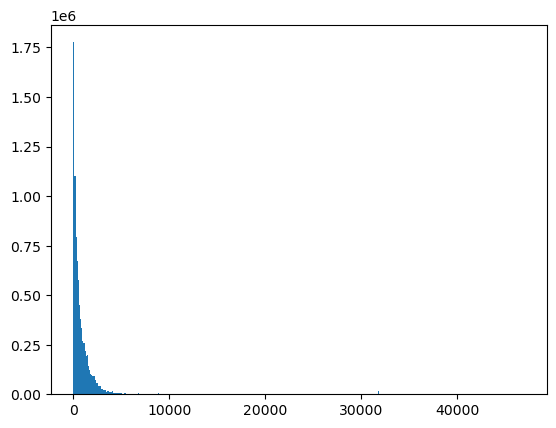

In [22]:
_ = plt.hist(sci_dist_df['pairdensity_avg'], bins=400)

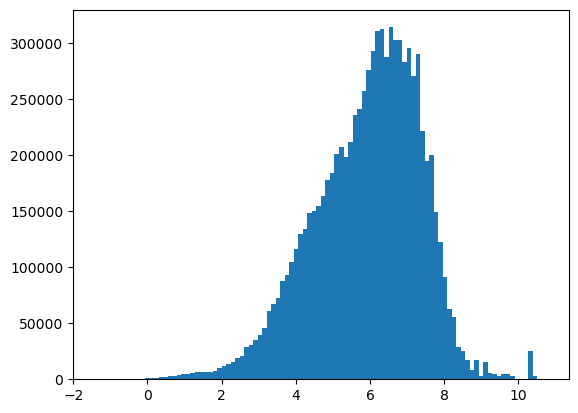

In [23]:
_ = plt.hist(np.log(sci_dist_df['pairdensity_avg']), bins=100)

<AxesSubplot:xlabel='log_pairdensity', ylabel='resid'>

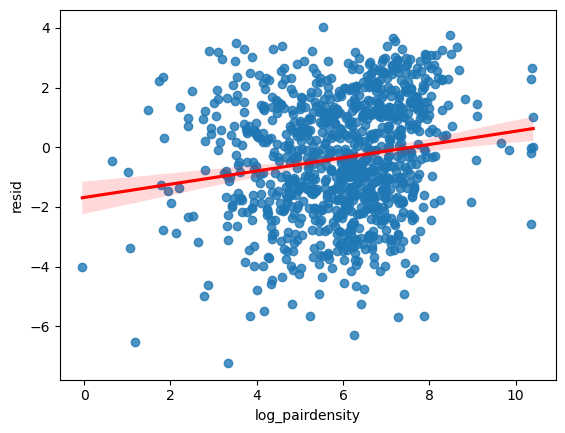

In [24]:
sci_dist_df['log_pairdensity'] = np.log(sci_dist_df['pairdensity_avg'])
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(data=sci_dist_df.iloc[samples], x='log_pairdensity', y='resid',
           line_kws={"color": "red"})
# plt.xlim(0, 25)

There is indeed a relationship between the residuals and the population density of the counties: as the population density of the counties increases, the residual increases as well. This means lower population density leads the regression to predict a lower social distance than actually observed. This makes sense, as in population sparse regions, friendships are likely farther apart.

Now, let's run a regression including both geographic distances and population density.

In [25]:
sci_dist_df['log_geo_dist'] = np.log(sci_dist_df['geo_dist'])
results = sm.OLS(sci_dist_df['value'], sci_dist_df[['log_geo_dist','log_pairdensity']]).fit()

sci_dist_df['geo_density_resid'] = results.resid

In [42]:
sci_dist_df.sort_values('geo_density_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,fr_density,pairdensity_avg,...,log_geo_dist,geo_density_resid,knn_resid,user_center_long,user_center_lat,user_loc,fr_center_long,fr_center_lat,fr_loc,knn_xy_resid
6068040,0.000059,0.553737,51.464926,Aroostook,MAINE,Wheeler,OREGON,64.123718,0.797775,32.460746,...,3.940901,-0.001525,NaN,-68.598904,46.658926,23003,-120.027518,44.725998,41069,-0.000879
3113420,0.000059,0.553737,51.464926,Wheeler,OREGON,Aroostook,MAINE,0.797775,64.123718,32.460746,...,3.940901,-0.001525,NaN,-120.027518,44.725998,41069,-68.598904,46.658926,23003,-0.000879
4981416,0.000030,-0.439384,45.605319,Alpine,CALIFORNIA,Hamilton,NEW YORK,1.603597,3.747278,2.675438,...,3.820024,-0.001522,NaN,-119.820680,38.597204,6003,-74.497378,43.661139,36041,-0.000982
429569,0.000030,-0.439384,45.605319,Hamilton,NEW YORK,Alpine,CALIFORNIA,3.747278,1.603597,2.675438,...,3.820024,-0.001522,NaN,-74.497378,43.661139,36041,-119.820680,38.597204,6003,-0.000982
3234071,0.000069,0.820207,53.501240,Jefferson,WASHINGTON,Dukes,MASSACHUSETTS,503.625769,375.821071,439.723420,...,3.979705,-0.001513,NaN,-123.692862,47.784413,53031,-70.574278,41.397025,25007,-0.000803
8053945,0.000069,0.820207,53.501240,Dukes,MASSACHUSETTS,Jefferson,WASHINGTON,375.821071,503.625769,439.723420,...,3.979705,-0.001513,NaN,-70.574278,41.397025,25007,-123.692862,47.784413,53031,-0.000803
3137150,0.000047,0.239950,49.571403,Esmeralda,NEVADA,Penobscot,MAINE,0.298446,823.235945,411.767195,...,3.903414,-0.001504,NaN,-117.632324,37.784664,32009,-68.649461,45.400641,23019,-0.000824
4699967,0.000047,0.239950,49.571403,Penobscot,MAINE,Esmeralda,NEVADA,823.235945,0.298446,411.767195,...,3.903414,-0.001504,NaN,-68.649461,45.400641,23019,-117.632324,37.784664,32009,-0.000824
3129280,0.000090,1.103449,53.889555,San Juan,WASHINGTON,Knox,MAINE,159.117729,253.521529,206.319629,...,3.986937,-0.001500,NaN,-122.975021,48.607067,53055,-69.263687,44.227944,23013,-0.000400
8090367,0.000090,1.103449,53.889555,Knox,MAINE,San Juan,WASHINGTON,253.521529,159.117729,206.319629,...,3.986937,-0.001500,NaN,-69.263687,44.227944,23013,-122.975021,48.607067,53055,-0.000400


Now, the county pairings with unexpectadly high social connections are all very far apart, which is more of the kinds of pairs we're interested in.

In [27]:
# Tomkins county?
tc_df = sci_dist_df[sci_dist_df['user_loc']==36109]
tc_df.sort_values('geo_density_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,user_loc,fr_density,fr_loc,pairdensity_avg,log_pairdensity,log_geo_dist,geo_density_resid
6075,0.000082,0.618045,46.523924,Tompkins,NEW YORK,San Francisco,CALIFORNIA,3226.394468,36109,30508.122047,6075,16867.258257,9.733130,3.839967,-0.001418
41003,0.000132,1.127689,46.999944,Tompkins,NEW YORK,Benton,OREGON,3226.394468,36109,2794.955325,41003,3010.674897,8.009920,3.850146,-0.001383
6113,0.000125,0.994051,45.583730,Tompkins,NEW YORK,Yolo,CALIFORNIA,3226.394468,36109,4613.933952,6113,3920.164210,8.273889,3.819551,-0.001376
53055,0.000148,1.232342,46.906960,Tompkins,NEW YORK,San Juan,WASHINGTON,3226.394468,36109,159.117729,53055,1692.756098,7.434113,3.848166,-0.001371
6001,0.000137,1.084761,45.668617,Tompkins,NEW YORK,Alameda,CALIFORNIA,3226.394468,36109,10687.188302,6001,6956.791385,8.847474,3.821411,-0.001362
6085,0.000155,1.199665,45.521809,Tompkins,NEW YORK,Santa Clara,CALIFORNIA,3226.394468,36109,9198.375219,6085,6212.384844,8.734300,3.818192,-0.001343
53033,0.000161,1.242729,45.610724,Tompkins,NEW YORK,King,WASHINGTON,3226.394468,36109,6527.673365,53033,4877.033916,8.492293,3.820143,-0.001340
6057,0.000156,1.146226,44.406734,Tompkins,NEW YORK,Nevada,CALIFORNIA,3226.394468,36109,537.594206,6057,1881.994337,7.540087,3.793391,-0.001340
41051,0.000169,1.317371,46.045214,Tompkins,NEW YORK,Multnomah,OREGON,3226.394468,36109,7191.295190,41051,5208.844829,8.558113,3.829624,-0.001335
53031,0.000190,1.519124,47.519356,Tompkins,NEW YORK,Jefferson,WASHINGTON,3226.394468,36109,503.625769,53031,1865.010118,7.531022,3.861137,-0.001333


In [28]:
# Norfolk county?
nf_df = sci_dist_df[sci_dist_df['user_loc']==25021]
nf_df.sort_values('geo_density_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,user_loc,fr_density,fr_loc,pairdensity_avg,log_pairdensity,log_geo_dist,geo_density_resid
6075,0.000117,1.251672,51.708701,Norfolk,MASSACHUSETTS,San Francisco,CALIFORNIA,4433.220194,25021,30508.122047,6075,17470.671120,9.768279,3.945626,-0.001426
56039,0.000089,0.266914,39.394897,Norfolk,MASSACHUSETTS,Teton,WYOMING,4433.220194,25021,131.092401,56039,2282.156297,7.732876,3.673636,-0.001357
6041,0.000203,1.802464,51.645255,Norfolk,MASSACHUSETTS,Marin,CALIFORNIA,4433.220194,25021,5154.906711,6041,4794.063453,8.475134,3.944398,-0.001348
8113,0.000103,0.275764,37.396065,Norfolk,MASSACHUSETTS,San Miguel,COLORADO,4433.220194,25021,54.026520,8113,2243.623357,7.715847,3.621565,-0.001322
8097,0.000091,0.043197,35.797549,Norfolk,MASSACHUSETTS,Pitkin,COLORADO,4433.220194,25021,134.556987,8097,2283.888590,7.733635,3.577879,-0.001316
49043,0.000134,0.702864,39.738579,Norfolk,MASSACHUSETTS,Summit,UTAH,4433.220194,25021,307.808277,49043,2370.514236,7.770862,3.682322,-0.001315
6081,0.000270,2.070909,51.307502,Norfolk,MASSACHUSETTS,San Mateo,CALIFORNIA,4433.220194,25021,9540.881953,6081,6987.051074,8.851814,3.937837,-0.001276
8117,0.000145,0.444393,34.967911,Norfolk,MASSACHUSETTS,Summit,COLORADO,4433.220194,25021,55.561999,8117,2244.391097,7.716190,3.554431,-0.001252
53033,0.000294,2.133402,50.853045,Norfolk,MASSACHUSETTS,King,WASHINGTON,4433.220194,25021,6527.673365,53033,5480.446779,8.608942,3.928940,-0.001249
6051,0.000287,1.948164,47.832952,Norfolk,MASSACHUSETTS,Mono,CALIFORNIA,4433.220194,25021,70.753647,6051,2251.986921,7.719568,3.867715,-0.001238


In [29]:
# cook county?
cc_df = sci_dist_df[sci_dist_df['user_loc']==17031]
cc_df.sort_values('geo_density_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,user_loc,fr_density,fr_loc,pairdensity_avg,log_pairdensity,log_geo_dist,geo_density_resid
6075,0.000143,0.446537,35.179980,Cook,ILLINOIS,San Francisco,CALIFORNIA,13472.458286,17031,30508.122047,6075,21990.290166,9.998356,3.560477,-0.001241
32003,0.000197,0.153444,27.772397,Cook,ILLINOIS,Clark,NEVADA,13472.458286,17031,6728.335150,32003,10100.396718,9.220330,3.324043,-0.001095
53033,0.000286,1.088001,34.454972,Cook,ILLINOIS,King,WASHINGTON,13472.458286,17031,6527.673365,53033,10000.065825,9.210347,3.539653,-0.001095
41051,0.000304,1.173587,34.796019,Cook,ILLINOIS,Multnomah,OREGON,13472.458286,17031,7191.295190,41051,10331.876738,9.242989,3.549503,-0.001081
6041,0.000327,1.269455,35.109347,Cook,ILLINOIS,Marin,CALIFORNIA,13472.458286,17031,5154.906711,6041,9313.682498,9.139240,3.558467,-0.001062
6037,0.000282,0.828807,31.370685,Cook,ILLINOIS,Los Angeles,CALIFORNIA,13472.458286,17031,13535.741916,6037,13504.100101,9.510749,3.445874,-0.001058
6001,0.000323,1.198084,34.329093,Cook,ILLINOIS,Alameda,CALIFORNIA,13472.458286,17031,10687.188302,6001,12079.823294,9.399292,3.535993,-0.001055
4013,0.000216,0.081335,26.094757,Cook,ILLINOIS,Maricopa,ARIZONA,13472.458286,17031,5010.698571,4013,9241.578428,9.131468,3.261734,-0.001052
8097,0.000120,-1.298100,19.279156,Cook,ILLINOIS,Pitkin,COLORADO,13472.458286,17031,134.556987,8097,6803.507636,8.825194,2.959025,-0.001027
56039,0.000191,-0.387215,22.869181,Cook,ILLINOIS,Teton,WYOMING,13472.458286,17031,131.092401,56039,6801.775343,8.824939,3.129790,-0.001025


These results are cetainly a step forward. Still, they aren't perfect. The main problem in my opinion is the model really favors counties that are very far apart. Really, the relationship between social distance and geographical distance is likely nonlinear, such that after a certain geographical distance, social distances likely stop decreasing nearly as much. Let's try a regression capable of modeling these non-linearities: a K-nearest neighbors regression should do the trick.

In [30]:
n_neighbors = 50
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=50, weights='uniform')
X = sci_dist_df[['log_geo_dist','log_pairdensity']]
# X = sci_dist_df[['log_geo_dist']]
y = sci_dist_df['value']
results = knn_model.fit(X, y)

In [31]:
if n_neighbors > 20:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_resid'] = residuals
else:
    # predict in batches (to avoid memory error)
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_resid'] = np.asarray(Yy - predictions)

In [32]:
sci_dist_df.sort_values('knn_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,user_loc,fr_density,fr_loc,pairdensity_avg,log_pairdensity,log_geo_dist,geo_density_resid,knn_resid
34031,0.000775,1.484072,27.380936,McMullen,TEXAS,Passaic,NEW JERSEY,0.588700,48311,12954.955888,34031,6477.772294,8.776132,3.309847,-0.000515,-0.005828
48311,0.000775,1.484072,27.380936,Passaic,NEW JERSEY,McMullen,TEXAS,12954.955888,34031,0.588700,48311,6477.772294,8.776132,3.309847,-0.000515,-0.005828
6073,0.000611,1.257153,27.493247,Rock Island,ILLINOIS,San Diego,CALIFORNIA,2705.695913,17161,7308.020788,6073,5006.858350,8.518564,3.313940,-0.000682,-0.005678
17161,0.000611,1.257153,27.493247,San Diego,CALIFORNIA,Rock Island,ILLINOIS,7308.020788,6073,2705.695913,17161,5006.858350,8.518564,3.313940,-0.000682,-0.005678
48121,0.000475,0.745935,24.905768,Santa Clara,CALIFORNIA,Denton,TEXAS,9198.375219,6085,3642.970385,48121,6420.672802,8.767278,3.215099,-0.000777,-0.005630
6085,0.000475,0.745935,24.905768,Denton,TEXAS,Santa Clara,CALIFORNIA,3642.970385,48121,9198.375219,6085,6420.672802,8.767278,3.215099,-0.000777,-0.005630
6037,0.001245,1.790249,25.676813,Kandiyohi,MINNESOTA,Los Angeles,CALIFORNIA,1066.322638,27067,13535.741916,6037,7301.032277,8.895771,3.245588,-0.000018,-0.005409
27067,0.001245,1.790249,25.676813,Los Angeles,CALIFORNIA,Kandiyohi,MINNESOTA,13535.741916,6037,1066.322638,27067,7301.032277,8.895771,3.245588,-0.000018,-0.005409
48157,0.000607,0.991665,24.900241,Westchester,NEW YORK,Fort Bend,TEXAS,9725.993594,36119,3049.135122,48157,6387.564358,8.762108,3.214877,-0.000644,-0.005338
36119,0.000607,0.991665,24.900241,Fort Bend,TEXAS,Westchester,NEW YORK,3049.135122,48157,9725.993594,36119,6387.564358,8.762108,3.214877,-0.000644,-0.005338


In [33]:
# cook county?
cc_df = sci_dist_df[sci_dist_df['user_loc']==36109]
cc_df.sort_values('knn_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,user_loc,fr_density,fr_loc,pairdensity_avg,log_pairdensity,log_geo_dist,geo_density_resid,knn_resid
8069,0.000172,0.133893,29.042462,Tompkins,NEW YORK,Larimer,COLORADO,3226.394468,36109,2903.813689,8069,3065.104078,8.027837,3.368759,-0.001147,-0.002274
20161,0.000190,-0.677509,20.505801,Tompkins,NEW YORK,Riley,KANSAS,3226.394468,36109,2578.839827,20161,2902.617147,7.973368,3.020708,-0.000988,-0.002080
8113,0.000068,-0.517150,32.240556,Tompkins,NEW YORK,San Miguel,COLORADO,3226.394468,36109,54.026520,8113,1640.210494,7.402580,3.473225,-0.001298,-0.001925
8015,0.000198,0.351874,29.950549,Tompkins,NEW YORK,Chaffee,COLORADO,3226.394468,36109,291.119726,8015,1758.757097,7.472363,3.399548,-0.001138,-0.001833
12113,0.000439,-0.522376,15.791370,Tompkins,NEW YORK,Santa Rosa,FLORIDA,3226.394468,36109,860.391712,12113,2043.393090,7.622367,2.759464,-0.000634,-0.001787
32003,0.000559,2.083288,39.041288,Tompkins,NEW YORK,Clark,NEVADA,3226.394468,36109,6728.335150,32003,4977.364809,8.512656,3.664620,-0.000878,-0.001759
12021,0.000303,-0.692864,17.052679,Tompkins,NEW YORK,Collier,FLORIDA,3226.394468,36109,2275.999857,12021,2751.197162,7.919791,2.836307,-0.000800,-0.001715
53075,0.000157,0.963173,41.289818,Tompkins,NEW YORK,Whitman,WASHINGTON,3226.394468,36109,2560.100990,53075,2893.247729,7.970135,3.720616,-0.001306,-0.001711
6057,0.000156,1.146226,44.406734,Tompkins,NEW YORK,Nevada,CALIFORNIA,3226.394468,36109,537.594206,6057,1881.994337,7.540087,3.793391,-0.001340,-0.001626
8031,0.000141,-0.116227,28.524001,Tompkins,NEW YORK,Denver,COLORADO,3226.394468,36109,7957.255161,8031,5591.824814,8.629061,3.350746,-0.001167,-0.001560


Try including x, y coords in model -- how many friendships do we expect, based off nearby counties?

In [34]:
# Get x, y coords
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)

# Convert r Polygon text to shapely polygon
for row_idx, row in county_data.iterrows():
    points = re.findall(r'-?\d+.\d+', row['geometry'].wkt)
    i = 0
    list_points = []
    while i < len(points):
        list_points.append((float(points[i]), float(points[i+1])))
        i+=2
    list_points

    county_shape = Polygon(list_points)
    county_center = county_shape.centroid
    center_points = re.findall(r'-?\d+.\d+', county_center.wkt)
    county_data.at[row_idx, 'center_long'] = float(center_points[0])
    county_data.at[row_idx, 'center_lat'] = float(center_points[1])

In [35]:
# Try including x, y coords in model
county_data = county_data.set_index('fips')
center_loc = county_data.loc[:, ['center_long', 'center_lat']]
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'user_center_long', 'center_lat':'user_center_lat'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'fr_center_long', 'center_lat':'fr_center_lat'})

In [43]:
n_neighbors = 5

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
X = sci_dist_df[['user_center_long','user_center_lat','fr_center_long','fr_center_lat']]
y = sci_dist_df['value']
results = knn_model.fit(X, y)

if n_neighbors < 25:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_xy_resid'] = residuals

else: #predict in batch to avoid memory error
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_xy_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_xy_resid'] = np.asarray(Yy - predictions)


In [44]:
sci_dist_df.sort_values('knn_xy_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,fr_density,pairdensity_avg,...,log_geo_dist,geo_density_resid,knn_resid,user_center_long,user_center_lat,user_loc,fr_center_long,fr_center_lat,fr_loc,knn_xy_resid
3230792,0.004348,3.679817,32.796044,Gaines,TEXAS,Bristol,MASSACHUSETTS,864.454961,4241.219431,2552.837196,...,3.490308,0.002978,NaN,-102.635192,32.740755,48165,-71.114377,41.797174,25005,-0.015344
7049566,0.004348,3.679817,32.796044,Bristol,MASSACHUSETTS,Gaines,TEXAS,4241.219431,864.454961,2552.837196,...,3.490308,0.002978,NaN,-71.114377,41.797174,25005,-102.635192,32.740755,48165,-0.015344
6262509,0.003610,3.454197,32.301640,Gaines,TEXAS,Kent,RHODE ISLAND,864.454961,2667.887849,1766.171405,...,3.475118,0.002244,NaN,-102.635192,32.740755,48165,-71.592878,41.672199,44003,-0.015149
7050623,0.003610,3.454197,32.301640,Kent,RHODE ISLAND,Gaines,TEXAS,2667.887849,864.454961,1766.171405,...,3.475118,0.002244,NaN,-71.592878,41.672199,44003,-102.635192,32.740755,48165,-0.015149
6265485,0.004000,3.581307,32.606678,Gaines,TEXAS,Newport,RHODE ISLAND,864.454961,2320.995860,1592.725411,...,3.484517,0.002629,NaN,-102.635192,32.740755,48165,-71.240612,41.548468,44005,-0.014781
7050624,0.004000,3.581307,32.606678,Newport,RHODE ISLAND,Gaines,TEXAS,2320.995860,864.454961,1592.725411,...,3.484517,0.002629,NaN,-71.240612,41.548468,44005,-102.635192,32.740755,48165,-0.014781
6268455,0.004237,3.619890,32.369807,Gaines,TEXAS,Providence,RHODE ISLAND,864.454961,7073.736050,3969.095506,...,3.477226,0.002876,NaN,-102.635192,32.740755,48165,-71.580046,41.872149,44007,-0.014040
7050625,0.004237,3.619890,32.369807,Providence,RHODE ISLAND,Gaines,TEXAS,7073.736050,864.454961,3969.095506,...,3.477226,0.002876,NaN,-71.580046,41.872149,44007,-102.635192,32.740755,48165,-0.014040
7050626,0.005025,3.778107,32.217639,Washington,RHODE ISLAND,Gaines,TEXAS,960.067504,864.454961,912.261233,...,3.472514,0.003655,NaN,-71.622597,41.469743,44009,-102.635192,32.740755,48165,-0.013734
6271420,0.005025,3.778107,32.217639,Gaines,TEXAS,Washington,RHODE ISLAND,864.454961,960.067504,912.261233,...,3.472514,0.003655,NaN,-102.635192,32.740755,48165,-71.622597,41.469743,44009,-0.013734


In [45]:
# Tompkins county?
tc_df = sci_dist_df[sci_dist_df['user_loc']==36109]
tc_df.sort_values('knn_xy_resid', ascending=True).head(20)

,value,resid,geo_dist,user_county,user_state,fr_county,fr_state,user_density,fr_density,pairdensity_avg,...,log_geo_dist,geo_density_resid,knn_resid,user_center_long,user_center_lat,user_loc,fr_center_long,fr_center_lat,fr_loc,knn_xy_resid
6929572,0.003559,3.047834,27.800431,Tompkins,NEW YORK,Cochran,TEXAS,3226.394468,3.812500,1615.103484,...,3.325052,0.002253,NaN,-76.47364,42.452035,36109,-102.828515,33.604182,48079,-0.003541
2517585,0.002037,2.301359,25.866219,Tompkins,NEW YORK,Morton,KANSAS,3226.394468,4.156326,1615.275397,...,3.252938,0.000760,NaN,-76.47364,42.452035,36109,-101.799258,37.191395,20129,-0.003229
2473821,0.001618,1.801889,23.331454,Tompkins,NEW YORK,Kiowa,KANSAS,3226.394468,3.487214,1614.940841,...,3.149802,0.000384,NaN,-76.47364,42.452035,36109,-99.286080,37.558230,20097,-0.002704
7490836,0.002786,2.743116,27.171789,Tompkins,NEW YORK,Webb,TEXAS,3226.394468,5257.810833,4242.102650,...,3.302179,0.001496,NaN,-76.47364,42.452035,36109,-99.331527,27.761117,48479,-0.002610
7355837,0.003268,2.924026,27.392903,Tompkins,NEW YORK,Reagan,TEXAS,3226.394468,3.084282,1614.739375,...,3.310284,0.001968,NaN,-76.47364,42.452035,36109,-101.523107,31.366218,48383,-0.002556
326733,0.002433,1.262501,16.235251,Tompkins,NEW YORK,Lee,ARKANSAS,3226.394468,129.738527,1678.066497,...,2.787185,0.001347,NaN,-76.47364,42.452035,36109,-90.782149,34.780664,5077,-0.002524
5420882,0.001754,2.111579,25.467444,Tompkins,NEW YORK,Grant,NORTH DAKOTA,3226.394468,1.427839,1613.911153,...,3.237401,0.000484,NaN,-76.47364,42.452035,36109,-101.639725,46.358294,38037,-0.002466
2586433,0.000975,1.386987,24.168067,Tompkins,NEW YORK,Sheridan,KANSAS,3226.394468,26.172517,1626.283492,...,3.185032,-0.000274,NaN,-76.47364,42.452035,36109,-100.441848,39.350354,20179,-0.002369
321598,0.001842,1.456268,19.452460,Tompkins,NEW YORK,Lafayette,ARKANSAS,3226.394468,20.156499,1623.275484,...,2.967974,0.000682,NaN,-76.47364,42.452035,36109,-93.607061,33.240951,5073,-0.002252
6574953,0.001364,1.844771,25.318740,Tompkins,NEW YORK,Ziebach,SOUTH DAKOTA,3226.394468,1.436850,1613.915659,...,3.231545,0.000097,NaN,-76.47364,42.452035,36109,-101.665818,44.980428,46137,-0.002203


TODO: try including x, y coords in model